# Feature and Model Selection

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold


Bad key "text.kerning_factor" on line 4 in
C:\Users\leejl\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Read in data

In [2]:
df_train = pd.read_csv(r'.\modified_data\cleantrain.csv')
df_test = pd.read_csv(r'.\modified_data\cleantest.csv')

power_transforms_to_do = {'Gr Liv Area': 'try Squared',
                          'Garage Area': 'try Squared',
                          'Lot Area': 'try log'}

features_to_dummy = [
    'Garage Finish',
    'Mas Vnr Type',
    'MS Zoning',
    'Lot Shape',
    'Neighborhood',
    'Bldg Type',
    'House Style']

### Check some histograms for distributions of non-binary features:

In [3]:
df_train.columns.values

array(['MS Zoning', 'Lot Area', 'Lot Shape', 'Neighborhood', 'Bldg Type',
       'House Style', 'Mas Vnr Type', 'Exter Qual', 'Bsmt Qual',
       'Bsmt Exposure', 'Total Bsmt SF', 'Heating QC', 'Central Air',
       '1st Flr SF', 'Gr Liv Area', 'Kitchen AbvGr', 'Kitchen Qual',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Paved Drive',
       'SalePrice', 'has_alley', 'has_fence', 'has_fireplace',
       'Total Bsmt Bath', 'total_baths', 'on_cds', 'Overall Goodness'],
      dtype=object)

In [4]:
non_binary_features = ['Lot Area',
                        'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure',
                       'Total Bsmt SF', 'Heating QC', '1st Flr SF',
                       'Gr Liv Area', 'Kitchen AbvGr', 'Kitchen Qual', 'Garage Finish',
                       'Garage Cars', 'Garage Area', 'SalePrice', 'Total Bsmt Bath',
                       'total_baths', 'Overall Goodness']

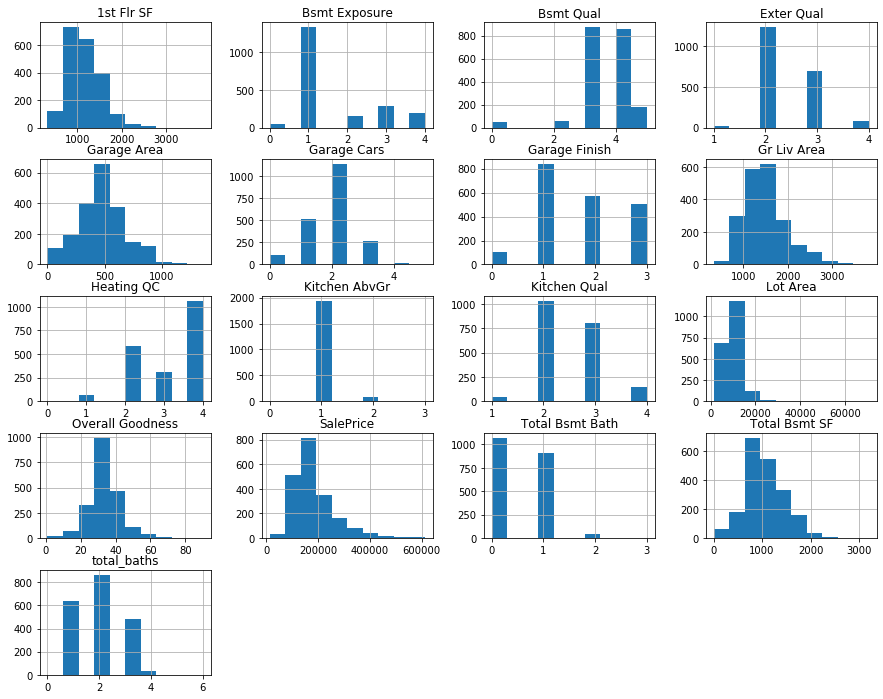

In [5]:
df_train[non_binary_features].hist(figsize = (15,12));

### Transform Some Features with Logarithms

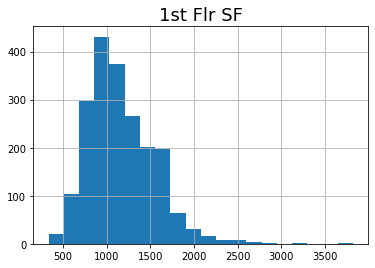

In [6]:
# look at the skewed continuous variables, test transforms
df_train['1st Flr SF'].hist(bins = 20)
plt.title('1st Flr SF', fontdict={'fontsize': 18});

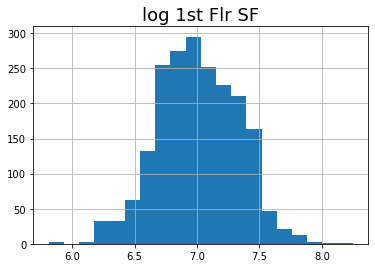

In [7]:
# check out the log for a more normal distribution
df_train['log 1st Flr SF'] = np.log(df_train['1st Flr SF'])
df_train['log 1st Flr SF'].hist(bins = 20)
plt.title('log 1st Flr SF', fontdict={'fontsize': 18});

In [8]:
# repeat on df_test
df_test['log 1st Flr SF'] = np.log(df_test['1st Flr SF'])

# list to keep track of transformed features
logged_features = ['log 1st Flr SF']

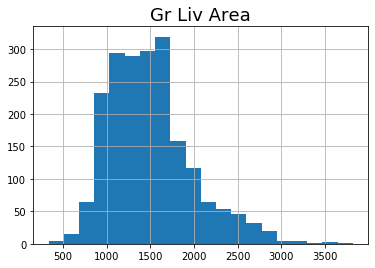

In [9]:
df_train['Gr Liv Area'].hist(bins = 20)
plt.title('Gr Liv Area', fontdict={'fontsize': 18});

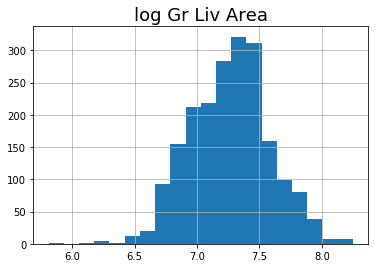

In [10]:
df_train['log Gr Liv Area'] = np.log(df_train['Gr Liv Area'])
df_train['log Gr Liv Area'].hist(bins = 20)
plt.title('log Gr Liv Area', fontdict={'fontsize': 18});

In [11]:
# repeat on df_test
df_test['log Gr Liv Area'] = np.log(df_test['Gr Liv Area'])

# keep track
logged_features.append('log Gr Liv Area')

### Engineer a Total SF Feature

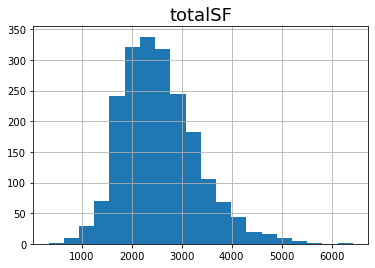

In [12]:
df_train['totalSF'] = df_train['Total Bsmt SF'] + df_train['Gr Liv Area']
df_test['totalSF'] = df_test['Total Bsmt SF'] + df_test['Gr Liv Area']
df_train['totalSF'].hist(bins = 20)
plt.title('totalSF', fontdict={'fontsize': 18});

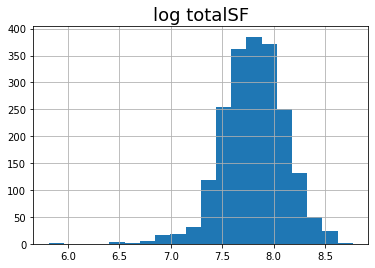

In [13]:
df_train['log totalSF'] = np.log(df_train['totalSF'])
df_test['log totalSF'] = np.log(df_test['totalSF'])
df_train['log totalSF'].hist(bins = 20)
plt.title('log totalSF', fontdict={'fontsize': 18});

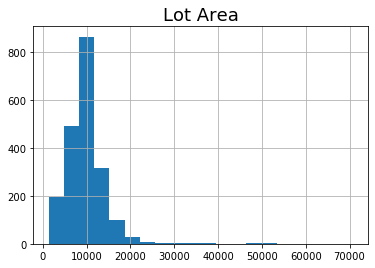

In [14]:
# look at Lot Area
df_train['Lot Area'].hist(bins = 20)
plt.title('Lot Area', fontdict={'fontsize': 18});

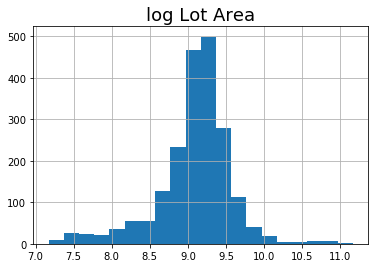

In [15]:
np.log(df_train['Lot Area']).hist(bins = 20)
plt.title('log Lot Area', fontdict={'fontsize': 18});

In [16]:
# keep the log
df_train['log Lot Area'] = np.log(df_train['Lot Area'])
df_test['log Lot Area'] = np.log(df_test['Lot Area'])

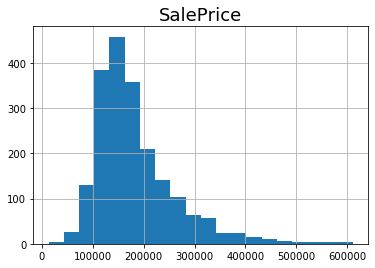

In [17]:
# check out target
df_train['SalePrice'].hist(bins = 20)
plt.title('SalePrice', fontdict={'fontsize': 18});

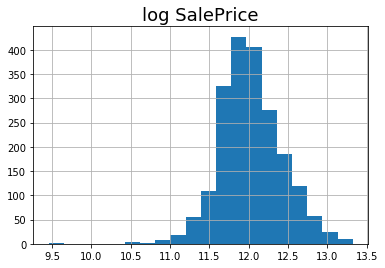

In [18]:
np.log(df_train['SalePrice']).hist(bins = 20)
plt.title('log SalePrice', fontdict={'fontsize': 18});

In [19]:
#NOTE: will try models with log target

### Correlation Heatmap for Reference

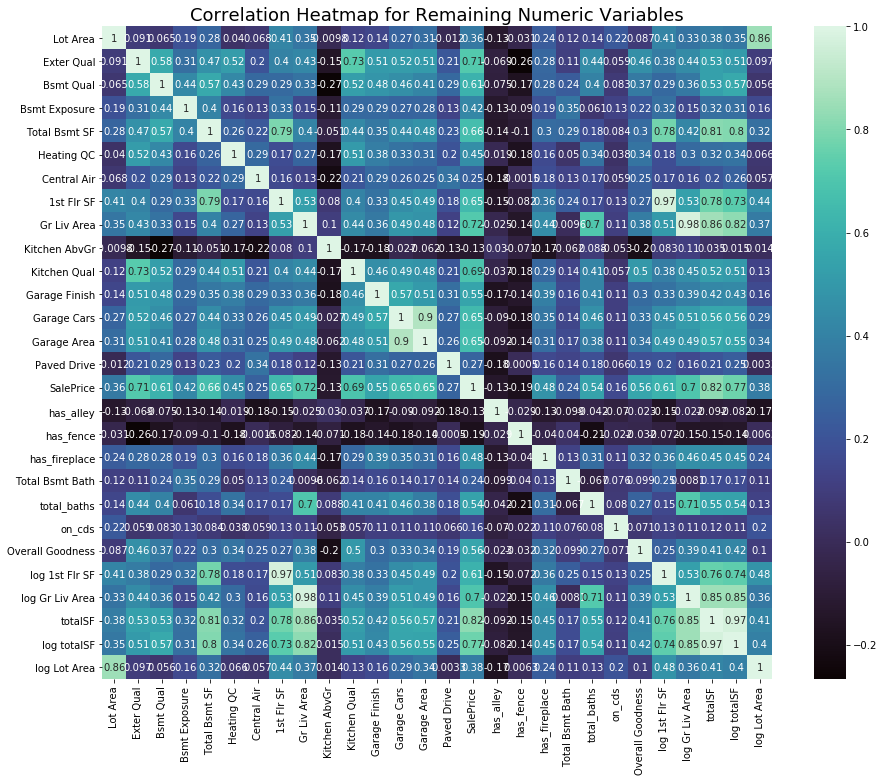

In [20]:
plt.figure(figsize=(15,12))
sns.heatmap(df_train.corr(), cmap='mako', annot=True)
plt.title('Correlation Heatmap for Remaining Numeric Variables', fontdict={'fontsize':18});

### Create some dataframes with different subsets of features to test

In [21]:
non_binary_features_without_logs = ['Lot Area',
                        'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure',
                       'Total Bsmt SF', 'Heating QC', '1st Flr SF',
                       'Gr Liv Area', 'Kitchen AbvGr', 'Kitchen Qual', 'Garage Finish',
                       'Garage Cars', 'Garage Area', 'Total Bsmt Bath',
                       'total_baths', 'Overall Goodness', 'totalSF']

non_binary_features_with_logs = ['log Lot Area',
                        'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure',
                       'Total Bsmt SF', 'Heating QC', 'log 1st Flr SF',
                       'log Gr Liv Area', 'Kitchen AbvGr', 'Kitchen Qual', 'Garage Finish',
                       'Garage Cars', 'Garage Area', 'Total Bsmt Bath',
                       'total_baths', 'Overall Goodness', 'log totalSF']

In [22]:
df_train.columns.values

array(['MS Zoning', 'Lot Area', 'Lot Shape', 'Neighborhood', 'Bldg Type',
       'House Style', 'Mas Vnr Type', 'Exter Qual', 'Bsmt Qual',
       'Bsmt Exposure', 'Total Bsmt SF', 'Heating QC', 'Central Air',
       '1st Flr SF', 'Gr Liv Area', 'Kitchen AbvGr', 'Kitchen Qual',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Paved Drive',
       'SalePrice', 'has_alley', 'has_fence', 'has_fireplace',
       'Total Bsmt Bath', 'total_baths', 'on_cds', 'Overall Goodness',
       'log 1st Flr SF', 'log Gr Liv Area', 'totalSF', 'log totalSF',
       'log Lot Area'], dtype=object)

#### Testing Dataframes with Binary Features and No Dummy Variables

In [23]:
# all testing dataframes are targetless
# our y variable for model testing will always be y = df_train['SalePrice']

# w/ no dummies, no log transforms, separate SF
df1 = df_train.drop(columns = ['SalePrice', 'MS Zoning', 'Bldg Type', 'Total Bsmt SF','log Lot Area', 'log totalSF', 'log 1st Flr SF', 'log Gr Liv Area', 'Garage Finish', 'Mas Vnr Type', 'Lot Shape', 'Neighborhood', 'House Style'])

# w/ no dummies, log transforms, separate SF
df2 = df_train.drop(columns = ['SalePrice', 'MS Zoning', 'Bldg Type', 'Total Bsmt SF', 'Lot Area', 'log totalSF', '1st Flr SF', 'Gr Liv Area', 'Garage Finish', 'Mas Vnr Type', 'Lot Shape', 'Neighborhood', 'House Style'])

# w/ no dummies, no log transforms, combined SF
df3 = df_train.drop(columns = ['SalePrice', 'MS Zoning', 'Bldg Type', 'log Lot Area', 'log totalSF', 'log 1st Flr SF', 'log Gr Liv Area', '1st Flr SF', 'Gr Liv Area', 'Garage Finish', 'Mas Vnr Type', 'Lot Shape', 'Neighborhood', 'House Style'])

# w/ no dummies, log transforms, combined SF
df4 = df_train.drop(columns = ['SalePrice', 'MS Zoning', 'Bldg Type', 'totalSF', 'Lot Area', 'log 1st Flr SF', 'log Gr Liv Area', '1st Flr SF', 'Gr Liv Area', 'Garage Finish', 'Mas Vnr Type', 'Lot Shape', 'Neighborhood', 'House Style'])

#### Testing Dataframes without Binary Features and No Dummy Variables

In [24]:
# w/ no dummies, no log transforms, separate SF
dfcont1 = df_train[non_binary_features_without_logs].drop(columns=['totalSF'])

# w/ no dummies, log transforms, separate SF
dfcont2 = df_train[non_binary_features_with_logs].drop(columns=['log totalSF'])

# w/ no dummies, no log transforms, combined SF
dfcont3 = df_train[non_binary_features_without_logs].drop(columns=['Gr Liv Area', '1st Flr SF'])

# w/ no dummies, log transforms, combined SF
dfcont4 = df_train[non_binary_features_with_logs].drop(columns=['log Gr Liv Area', 'log 1st Flr SF'])

#### Testing Dataframes WITH Dummy Variables

In [25]:
df_dum = pd.get_dummies(df_train, columns = features_to_dummy, drop_first = True)
df_test_dum = pd.get_dummies(df_test, columns = features_to_dummy, drop_first = True)
print(df_dum.shape)
print(df_test_dum.shape)

(2025, 77)
(878, 78)


In [26]:
# check for dummy columns in TRAINING data that may not exist in testing data
[col for col in df_dum.columns.values if col not in df_test_dum.columns.values]

['SalePrice', 'Neighborhood_GrnHill', 'Neighborhood_Landmrk']

In [27]:
# df_test_dum doesn't have these, but the dimensionality is all wrong later without them
df_test_dum['Neighborhood_GrnHill'] = 0
df_test_dum['Neighborhood_Landmrk'] = 0

In [28]:
# w/ dummies, no log transforms, separate SF
dfd1 = df_dum.drop(columns = ['SalePrice', 'totalSF', 'log totalSF', 'log 1st Flr SF', 'log Gr Liv Area'])

# w/ dummies, log transforms, separate SF
dfd2 = df_dum.drop(columns = ['SalePrice', 'totalSF', 'log totalSF', '1st Flr SF', 'Gr Liv Area'])

# w/ dummies, no log transforms, combined SF
dfd3 = df_dum.drop(columns = ['SalePrice', 'log totalSF', 'log 1st Flr SF', 'log Gr Liv Area', '1st Flr SF', 'Gr Liv Area'])

# w/ dummies, log transforms, combined SF
dfd4 = df_dum.drop(columns = ['SalePrice', 'totalSF', 'log 1st Flr SF', 'log Gr Liv Area', '1st Flr SF', 'Gr Liv Area'])

In [29]:
df_subsets = [df1, df2, df3, df4, dfcont1, dfcont2, dfcont3, dfcont4, dfd1, dfd2, dfd3, dfd4]

### Basic Linear Regression

In [30]:
# function to test dataframes filtered for feature subsets

def lm_tester(df_subset):
    X = df_subset
    y = df_train['SalePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lm = LinearRegression()
    lm.fit(X_train, y_train)

    preds = lm.predict(X_test)

    resids = y_test - preds

    print(f'Training R2: {cross_val_score(lm, X_train, y_train).mean()}')
    print(f'Testing R2: {r2_score(y_test, preds)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds))}')
    print(f'Intercept: {lm.intercept_}')

    plt.title('Distribution of Errors')
    plt.hist(resids, bins=20);
    
def submission_gen_lm_tester(df, filename):
    X = df
    y = df_train['SalePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lm = LinearRegression()
    lm.fit(X_train, y_train)

    X_test_sub = df_test_dum[df.columns.values]
    sub_preds = lm.predict(X_test_sub)

    submission = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': sub_preds,})
    submission.to_csv(f'{filename}.csv', index=False)

Training R2: 0.8541821943990782
Testing R2: 0.8598358358290236
RMSE: 29506.230877569713
Intercept: -114135.23468966005


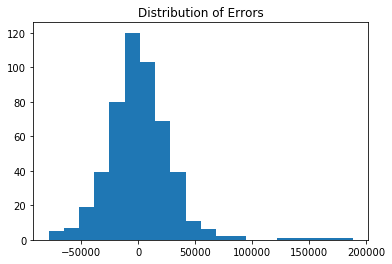

In [31]:
lm_tester(df1)

Training R2: 0.8533409204888862
Testing R2: 0.8532637679498077
RMSE: 30250.563983762047
Intercept: -121168.3684795807


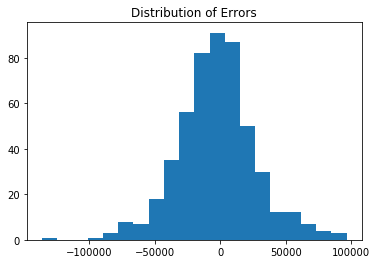

In [32]:
lm_tester(dfcont1)

Training R2: 0.8853133415932298
Testing R2: 0.8920074703733464
RMSE: 25824.78155256177
Intercept: -184372.16419694602


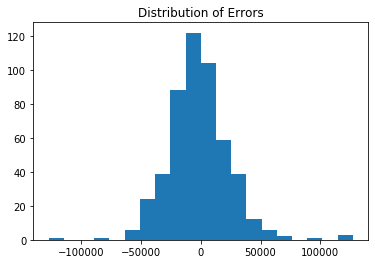

In [33]:
lm_tester(dfd3)

## Now with Lasso, Ridge, and Pipelines

In [34]:
# start with lasso
def lasso_tester(df):
    X = df
    y = df_train['SalePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    pipe = Pipeline([
        ('var_thresh', VarianceThreshold(threshold = 0.05)), # variance threshold 1st
        ('ss', StandardScaler()), # standard scaler 2nd
        ('kbest', SelectKBest(f_regression, k = 'all')), # k best 3rd
        ('lasso', Lasso()) # fit a lasso model
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    resids = y_test - preds
    
    print(f'Training R2: {cross_val_score(pipe, X_train, y_train).mean()}')
    print(f'Testing R2: {pipe.score(X_test, y_test)}')
    print(np.sqrt(mean_squared_error(y_test, preds)))
    
    plt.title('Distribution of Errors')
    plt.hist(resids, bins=20);
    
def ridge_tester(df):
    X = df
    y = df_train['SalePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    pipe = Pipeline([
        ('var_thresh', VarianceThreshold(threshold = 0.05)), # variance threshold 1st
        ('ss', StandardScaler()), # standard scaler 2nd
        ('kbest', SelectKBest(f_regression, k = 'all')), # k best 3rd
        ('ridge', Ridge()) # fit a Ridge model
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    resids = y_test - preds
    
    print(f'Training R2: {cross_val_score(pipe, X_train, y_train).mean()}')
    print(f'Testing R2: {pipe.score(X_test, y_test)}')
    print(np.sqrt(mean_squared_error(y_test, preds)))
    
    plt.title('Distribution of Errors')
    plt.hist(resids, bins=20);

Training R2: 0.8495905616288837
Testing R2: 0.8661676502501726
29310.673437664856


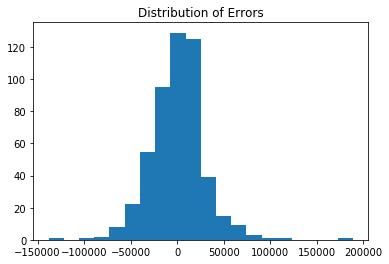

In [35]:
lasso_tester(df1)

Training R2: 0.8587536393321086
Testing R2: 0.8321981270590144
30434.874522446884


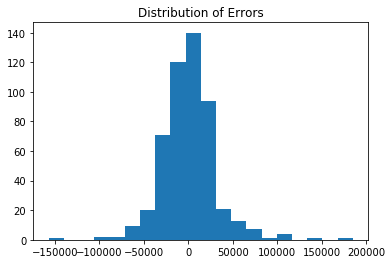

In [36]:
lasso_tester(dfcont3)

Training R2: 0.8753658038943708
Testing R2: 0.8590838290146382
29368.91573982472


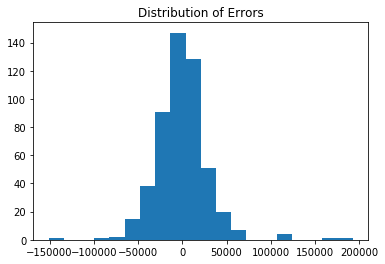

In [37]:
lasso_tester(dfd3)

In [38]:
# ridge models are all basically the same for each subset category

Training R2: 0.8629999300947724
Testing R2: 0.8348591009290727
34251.92775824033


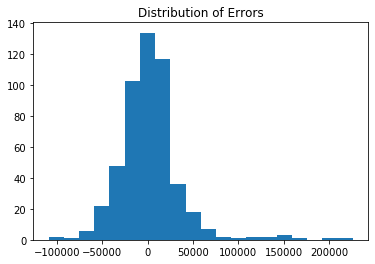

In [39]:
ridge_tester(df1)

Training R2: 0.8427295252649311
Testing R2: 0.874197317264243
27839.26846803899


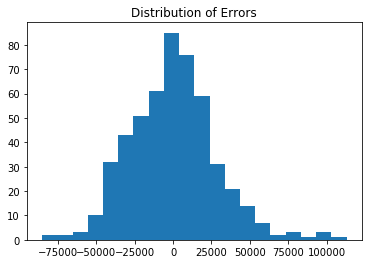

In [40]:
ridge_tester(dfcont3)

Training R2: 0.8674169351241297
Testing R2: 0.8696445117554581
27940.10108089735


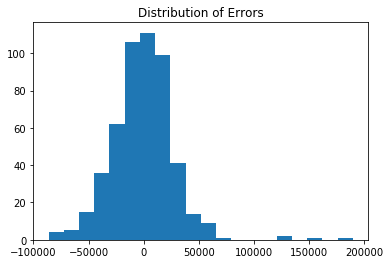

In [41]:
ridge_tester(dfd3)

## Best Model

Now we need to recreate this model and investigate coefficients.

In [53]:
X = dfd3
y = df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe = Pipeline([
    ('var_thresh', VarianceThreshold(threshold = 0.05)), # variance threshold 1st
    ('ss', StandardScaler()), # standard scaler 2nd
    ('kbest', SelectKBest(f_regression, k = 'all')), # k best 3rd
    ('linear', LinearRegression()) # fit a Ridge model
])

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
resids = y_test - preds

print(f'Training R2: {cross_val_score(pipe, X_train, y_train).mean()}')
print(f'Testing R2: {pipe.score(X_test, y_test)}')
print(np.sqrt(mean_squared_error(y_test, preds)))

Training R2: 0.8693834607925753
Testing R2: 0.8694217823249335
28456.694722344128


In [54]:
pipe.named_steps

{'var_thresh': VarianceThreshold(threshold=0.05),
 'ss': StandardScaler(copy=True, with_mean=True, with_std=True),
 'kbest': SelectKBest(k='all', score_func=<function f_regression at 0x000001DF888B6558>),
 'linear': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}

In [55]:
# get columns

columns = X.columns
columns = columns[pipe.named_steps['var_thresh'].get_support()]
columns = columns[pipe.named_steps['kbest'].get_support()]

In [56]:
best_betas = pd.DataFrame(data = pipe.named_steps['linear'].coef_,
             index = columns,
             columns = ['beta_1_s'])
best_betas.sort_values('beta_1_s')

,beta_1_s
Total Bsmt SF,-17553.032541
Neighborhood_OldTown,-3354.700045
Garage Finish_2,-3319.378557
Neighborhood_CollgCr,-2693.389516
Garage Finish_1,-2475.759075
Neighborhood_Edwards,-2091.569727
Bldg Type_TwnhsE,-1688.029306
Neighborhood_NAmes,-1462.241669
MS Zoning_RM,-1340.688740
has_alley,-1200.861067


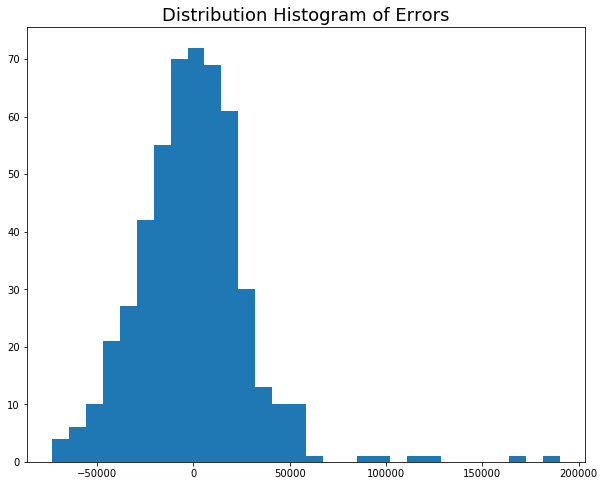

In [57]:
plt.figure(figsize = (10,8))
plt.title('Distribution Histogram of Errors', fontdict = {'fontsize': 18})
# plt.grid_l
plt.hist(resids, bins=30)
plt.savefig(r'.\besterrors.jpeg');

In [265]:
# create final submission
# generalized code for submissions, thanks to Brendan McDonnell

sub_preds = pipe.predict(df_test_dum[dfd3.columns.values])

submission = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': sub_preds})
submission.to_csv('filename.csv', index=False)